In [1]:
import os

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.pyplot as plt
import matplotlib.cm as com
import numpy as np

from scipy.signal import savgol_filter, find_peaks
from scipy.spatial import distance

from random import shuffle, uniform
import errno

In [2]:
# Standard Brian2 import
import brian2 as b2

b2.set_device('cpp_standalone')

import matplotlib.pyplot as plt
import os

import time
import pickle


b2.defaultclock.dt = 0.05*b2.ms
clock_dt = b2.defaultclock.dt

%matplotlib inline


In [3]:
include_state_monitor = {}
include_state_monitor['Input'] = False
include_state_monitor['Neurons'] = False
include_state_monitor['Small'] = False
include_state_monitor['Synapses'] = False
include_state_monitor['Output'] = False

In [4]:
N_per_edge = 20
N_o = 61
resting_time = 50

V_rest = -65
V_reset = -65
V_th = {}
V_th['Gyroscope'] = -59
V_th['Accelerometer'] = -59

#V_th = -60

tau_m = 30

tau_I_m = 5
tau_slow = 30
tau_I_i = 20


R_m = 1
R_slow = 0.1
R_i = 1

w_e = 20.0
w_i = 1

tau_r = 10
d_vt = 3.0

tau_trace = 500



taupre = 20.0
taupost = 20.0

Apre = 0.03125
Apost = - 1.05 * Apre
mApost = -1e-5
pApost = 1e-7


Apre_max = 10*Apre
Apost_max = 10*Apost


dw_plus = 0.1
dw_minus = 0.5
w_homeo_max = 2
tau_homeo = 100

I_m_max = 5000
I_i_max = w_i

wmax = 1.0
initial_weight_cte = 0.0
initial_weight_coef = 0.175
Apre *= wmax
#Apost *= wmax
Apre_max *=wmax
Apost_max *= wmax

refract_in = 0

max_synapses = 10



d_ngbr = 0.05*np.sqrt(3)
in_zone_d = 1.25*(1/(N_per_edge-1)) + (1e-6)

in_zone_d = (1/(N_per_edge-1)) + (1e-6)


N_i_small = 5
tau_small = 200
small_vth = 3

inputToSmallDst = 0.3



tau_inh = 10
tauvt = 400*b2.ms
filename = ''

In [5]:
# N_per_edge = 20
# N_o = 51
# resting_time = 50

# V_rest = -65
# V_reset = -65
# V_th = {}
# V_th['Gyroscope'] = -58
# V_th['Accelerometer'] = -58


# #V_th = -60

# tau_m = 30

# tau_I_m = 5
# tau_slow = 30
# tau_I_i = 20


# R_m = 1
# R_slow = 0.1
# R_i = 1

# w_e = 20.0
# w_i = 1

# tau_r = 10
# d_vt = 0.0

# tau_trace = 500



# taupre = 10.0
# taupost = 20.0

# Apre = 0.0125
# Apost = - 0.55 * Apre
# mApost = -1e-5
# pApost = 1e-7

# Apre_max = 10*Apre
# Apost_max = 10*Apost


# dw_plus = 0.1
# dw_minus = 0.5
# w_homeo_max = 2
# tau_homeo = 100

# I_m_max = 5000
# I_i_max = w_i

# wmax = 1.0
# initial_weight_cte = 0.0
# initial_weight_coef = 0.1
# Apre *= wmax
# #Apost *= wmax
# Apre_max *=wmax
# Apost_max *= wmax

# refract_in = 0

# max_synapses = 10



# d_ngbr = 0.05*np.sqrt(3)
# in_zone_d = (1/(N_per_edge-1)) + (1e-6)


# N_i_small = 5
# tau_small = 200
# small_vth = 3

# inputToSmallDst = 0.3



# tau_inh = 10
# tauvt = 400*b2.ms
# filename = ''

In [6]:
V_rest *= b2.mV
V_reset *= b2.mV
V_th['Gyroscope'] *= b2.mV
V_th['Accelerometer'] *= b2.mV
#V_th *= mV
tau_m *= b2.ms
tau_I_m *= b2.ms
tau_slow *= b2.ms
tau_I_i *= b2.ms
R_m *= b2.ohm
R_slow *= b2.ohm
R_i *= b2.ohm
w_e *= b2.mA
w_i *= b2.mA
I_i_max *= b2.mA
tau_r *= b2.ms
d_vt *= b2.mV
tau_trace *= b2.ms
taupre *= b2.ms
taupost *= b2.ms
tau_inh *= b2.ms
tau_homeo *= b2.ms
I_m_max *= b2.mA
refract_in *= b2.ms
resting_time *= b2.ms


In [7]:

if include_state_monitor['Input'] or include_state_monitor['Neurons'] or include_state_monitor['Output']:
    n_samples = 2
    n_reps_per_sample = 1
else:
    n_samples = 40
    n_reps_per_sample = 1

In [8]:
#Evenly distributed neurons within a cubea
class Nube:
    i = 0
    def __init__(self, n_nodes):
        self.n = n_nodes**3
        self.neighbour_dst = 2 / (n_nodes - 1)
        
        ps = np.linspace(-1,1,n_nodes)
        self.coordinates = [[[(x_,y_,z_) for z_ in ps] for y_ in ps] for x_ in ps]
        self.coordinates = [item for sublist in self.coordinates for item in sublist]
        self.coordinates = [item for sublist in self.coordinates for item in sublist]
        self.coordinates = {index: pos for index, pos in enumerate(self.coordinates)}
        self.x = [pos[0] for pos in self.coordinates.values()]
        self.y = [pos[1] for pos in self.coordinates.values()]
        self.z = [pos[2] for pos in self.coordinates.values()]

    def neighbour_neurons(self, i, p):        
        
        idxs = [i]
        
        for n in range(self.n):
            #print(self.neighbour_dst,distance.euclidean(p, self.coordinates[n]))
            if distance.euclidean(p, self.coordinates[n]) == self.neighbour_dst:
            #if distance.euclidean(p, self.coordinates[n]) == self.neighbour_dst or n == i:
                idxs.append(n)
                
        return idxs
    
    def get_coordinates(self, i):
        
        coords = []
        for neuron in self.neighbours[i]:
            coords.append(self.coordinates[neuron])
        
        coords.append(self.coordinates[i])
            
        return coords
    
    def closest_neuron(self, p):
        
        
        dst = 1000
        idx = -1
        
        for n in range(self.n):
            if distance.euclidean(p, self.coordinates[n]) < dst:
                dst = distance.euclidean(p, self.coordinates[n])
                idx = n
                #break if dst is smaller then possible distance (= /2)
        #print(idx)
        return idx
            
                    
    def scatter_neurons(self, ax):
        for n in range(self.n):
            x_,y_,z_ = self.coordinates[n]
            ax.scatter(x_,y_,z_, alpha = 0.5, c = 'cornflowerblue')
    plt.show()

In [9]:
def load_trial(dir_):
    
    g_x = []
    g_y = []
    g_z = []
    a_x = []
    a_y = []
    a_z = []
    tt = []

    file1 = open(dir_, 'r')

    lines = file1.readlines()

    for line in lines:
            word = line.split()
            try:
                    g_x.append(float(word[0]))
                    g_y.append(float(word[1]))
                    g_z.append(float(word[2]))
                    a_x.append(float(word[3]))
                    a_y.append(float(word[4]))
                    a_z.append(float(word[5]))
                    tt.append(float(word[6]))
            except:
                    pass
    file1.close()

    #data = pd.DataFrame([g_x,g_y,g_z, a_x,a_y,a_z])
    #data = data.transpose()
    #data.columns = ['gx', 'gy', 'gz', 'ax', 'ay', 'az']

    sensor_data = [g_x,g_y,g_z, a_x,a_y,a_z,tt]

    #for a,axis in enumerate(sensor_data):
    #    if a < 6:
    #        sensor_data[a][0] = 0
    #        sensor_data[a] = [value - axis[v-1] for v,value in enumerate(axis)]
            
    return [g_x,g_y,g_z, a_x,a_y,a_z,tt] #, data

def normalize_axis(s_axis):
    
    ret = [[] for s in s_axis]
    
    ret = s_axis.copy()
    
    for a,axis in enumerate(ret):
        for v, value in enumerate(axis):
            
            if ret[a][v] < 0:
                ret[a][v] = ret[a][v]/(32768)    # + 32767)
            else:
                ret[a][v] = ret[a][v]/(32767)   #+ 32768)
    
    return ret
        

In [10]:
dir_ = os.path.join(os.getcwd(), 'Dataset')
n_axis = 6

In [11]:
sample_frequency = 400*b2.Hz
desired_frequency = 100*b2.Hz

downFreqN = int(sample_frequency/desired_frequency)


Running in place
85.05263157894737
81.7948717948718
86.57894736842105
85.55263157894737
86.23076923076923
83.97560975609755


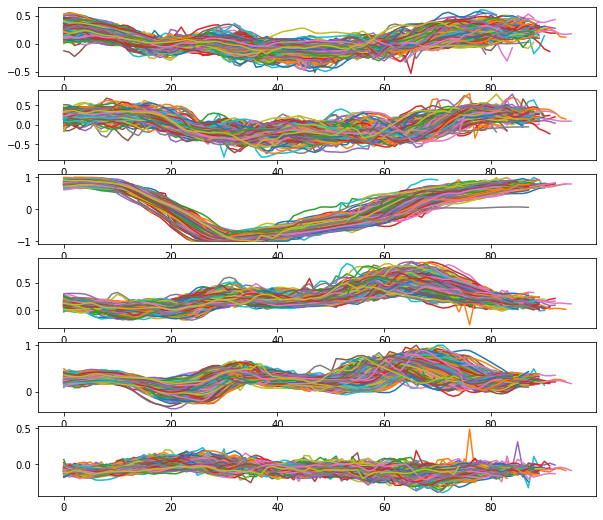

Torso rotation
174.16666666666666
171.5
189.48888888888888
179.28205128205127
179.57894736842104
179.02564102564102


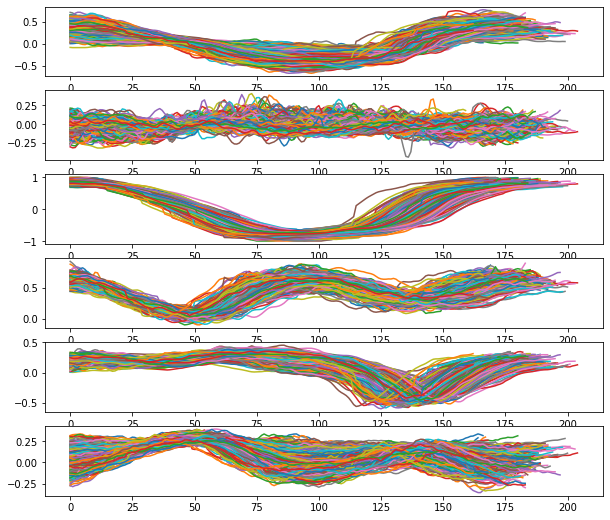

Jumping jacks
89.07894736842105
91.32432432432432
91.70454545454545
92.25
94.10810810810811
93.62162162162163


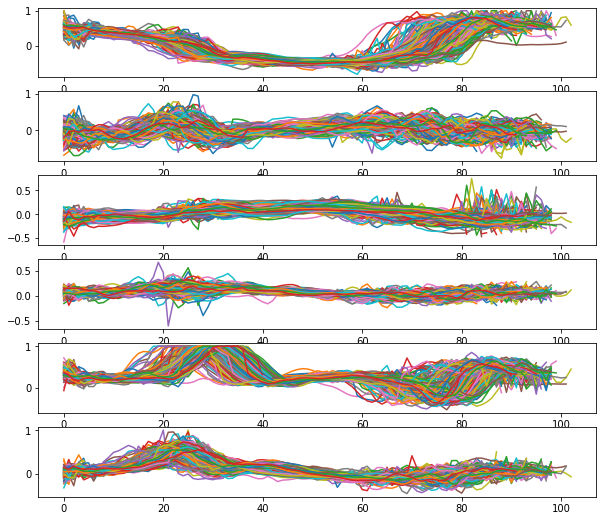

Touch feet
166.76923076923077
169.23076923076923
159.42857142857142
166.30769230769232
167.92857142857142
173.07142857142858
160.64285714285714
162.8
174.3846153846154
165.76923076923077
161.42857142857142
166.78571428571428
156.35714285714286
167.57142857142858
165.5
159.6153846153846


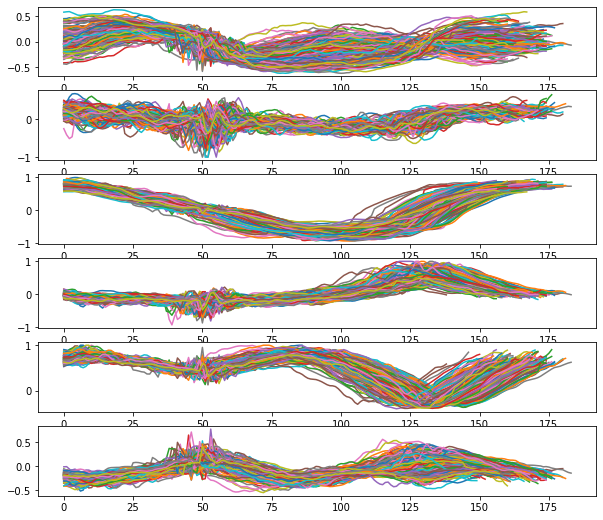

In [12]:
idxs = [[] for m in range(len(os.listdir(dir_)))]
movements_name = [[] for m in range(len(os.listdir(dir_)))]
samples = [[[] for n in range(n_axis)] for m in range(len(os.listdir(dir_)))]
n_peaks = [0 for m in range(len(os.listdir(dir_)))]

series = [[] for m in movements_name]
data = [[] for m in movements_name]

for m, movement in enumerate(os.listdir(dir_)):

    fig = plt.figure(figsize=(10, 9))
    axs = []
    for a in range(6):
        axs.append(fig.add_subplot(6, 1 , a+1))
    
    
    print(movement)
    movements_name[m] = movement
    
    movement_path = os.path.join(dir_, movement)
    
    n_trials = len(os.listdir(movement_path))
    
    idxs[m] = [[] for n in range(n_trials)]

    if 'Jumping' in movement:
        is_sin_like_axis = 0
        n_filters = 1
    elif 'Torso' in movement:
        is_sin_like_axis = 2
        n_filters = 1
    elif 'Running' in movement:
        is_sin_like_axis = 2
        n_filters = 1
    elif 'Touch' in movement:
        is_sin_like_axis = 2
        n_filters = 1
    else:
        print(movement)

    for tri, trial in enumerate(os.listdir(movement_path)):


        #[gx, gy, gz, ax, ay, az, t], _ = load_trial(os.path.join(movement_path, trial))
        [gx, gy, gz, ax, ay, az, dt] = load_trial(os.path.join(movement_path, trial))


        
        sensors_axis = [gx, gy, gz, ax, ay, az]
        sensors_axis = normalize_axis(sensors_axis)

        # is_sin_like_axis = index of axis in sensor_axis (0 : g_x, 1 : g_y, ..., 5 : a_z)
        # n_filters : number of times axis is filtered                
        

        #fig = plt.figure(figsize=(30, 20))
        #axs = []

        

        init_th = .3
        init = 0
        for i, val in enumerate(sensors_axis[is_sin_like_axis]):
            if val > init_th:
                init = i
                break
            
        _axis = [[] for a in range(len(sensors_axis))]
        for a,_ in enumerate(sensors_axis):
            _axis[a] = sensors_axis[a][init:]

        #for a, axis in enumerate(_axis):
        #    axs.append(fig.add_subplot(6, 1 , a+1))
        #    axs[-1].plot(np.arange(len(axis)), axis)
        
        filtered = savgol_filter(_axis[is_sin_like_axis], 51, 3)
        
        
        for n in range(n_filters):
            filtered = savgol_filter(filtered, 51, 3)

        #axs[is_sin_like_axis].plot(np.arange(len(filtered)), filtered)
        
        peaks = find_peaks(filtered, height=0)[0][1:-2]
        #diffs = [peaks[p+1]-peak for p, peak in enumerate(peaks[:-1])]
        #for p in peaks:
        #    axs[is_sin_like_axis].axvline(x=p, lw=0.75, c='black')

        #plt.show()


        
        #for p, peak in enumerate(peaks[2:-2]):
        #    idxs[m][t].append((peak, peaks[p+2]))
        
        avg_peak_dst = sum([peaks[p+1]-peak for p,peak in enumerate(peaks[:-1])])/(len(peaks)-1)
        print(avg_peak_dst)

        for p, peak in enumerate(peaks[:-1]):
            series_i= np.zeros((len(_axis), int(peaks[p+1]-peak)))
            for a, axis in enumerate(_axis):
                if peaks[p+1]-peak>0.85*avg_peak_dst and peaks[p+1]-peak<1.15*avg_peak_dst: 
                    series_i[a] = np.array(axis[peak:peaks[p+1]])

                    sample = np.array(axis[peak:peaks[p+1]])
                    #diff_sample = [value - sample[v-1] for v,value in enumerate(sample[1:], start=1)]
                    #sample = [0 for val in sample]
                    samples[m][a].append(sample)

                    axs[a].plot(np.arange(len(sample)), sample)
            series[m].append(series_i)
            
    plt.show()
        
        

In [13]:
for m,movement in enumerate(movements_name):
    print(f'Movement {movement} has {len(samples[m][0])} samples')

Movement Running in place has 229 samples
Movement Torso rotation has 254 samples
Movement Jumping jacks has 224 samples
Movement Touch feet has 219 samples


In [14]:
sensors = {'Gyroscope':[0,1,2], 'Accelerometer':[3,4,5]}
axis = {0:'x', 3:'x',1:'y', 4:'y',2:'z', 5:'z'}

In [15]:
movements_name

['Running in place', 'Torso rotation', 'Jumping jacks', 'Touch feet']

In [16]:

resting_array = [0.0 for _ in range(int(resting_time/(1/desired_frequency)))]


nu = Nube(N_per_edge)

N_i = nu.n
Input = {}
InputSpikeMonitor = {}
InputStateMonitor = {}
InputMonitor = {}
InputRateMonitor = {}

Synapse = {}



pattern_dt = 1/desired_frequency
elapsed_time=0*b2.ms
x = {sensor : [] for sensor in sensors}
y = {sensor : [] for sensor in sensors}
z = {sensor : [] for sensor in sensors}

# xd = {sensor : {event: list(resting_array) for event in ['on', 'off']} for sensor in sensors}
# yd = {sensor : {event: list(resting_array) for event in ['on', 'off']} for sensor in sensors}
# zd = {sensor : {event: list(resting_array) for event in ['on', 'off']} for sensor in sensors}



begins = []
durations = []
movement_index = []

iteration = []
it = 1

iteration_begin = []

movement_it = []

learning = []

events = [0,1,2,3,4,5]
event_type = {sensor: [] for sensor in sensors}



#for n in range(n_reps_per_sample):
for sp in range(n_samples):
    for m,movement in enumerate(movements_name):
        for s,sensor in enumerate(sensors):
            
            axis_x = sensors[sensor][0]
            axis_y = sensors[sensor][1]
            axis_z = sensors[sensor][2]

            x[sensor].extend(samples[m][axis_x][-1-sp])
            x[sensor].extend([x[sensor][-1] for r in range(len(resting_array))])

            y[sensor].extend(samples[m][axis_y][-1-sp])
            y[sensor].extend([y[sensor][-1] for r in range(len(resting_array))])

            z[sensor].extend(samples[m][axis_z][-1-sp])
            z[sensor].extend([z[sensor][-1] for r in range(len(resting_array))])




        sample_duration = len(samples[m][axis_x][-1-sp])
        
        learning.extend([1.0 for _ in range(int(sample_duration))])
        learning.extend([-1 for _ in range(len(resting_array))])

        iteration.extend([it for _ in range(int(sample_duration))])
        iteration.extend(resting_array)

        iteration_begin.extend([elapsed_time for _ in range(int(sample_duration))])
        iteration_begin.extend(resting_array)

        movement_it.extend([m for _ in range(int(sample_duration))])
        movement_it.extend([m for _ in range(len(resting_array))])

        begins.append(elapsed_time)
        durations.append(sample_duration*pattern_dt)
        movement_index.append(m)

        elapsed_time += sample_duration * pattern_dt + resting_time

    

    it += 1

is_learning = b2.TimedArray(learning, dt=pattern_dt)




In [17]:
elapsed_time

217.02 * second

In [18]:
x_sensor_0 = b2.TimedArray(x['Gyroscope'], dt=(1/desired_frequency))
y_sensor_0 = b2.TimedArray(y['Gyroscope'], dt=(1/desired_frequency))
z_sensor_0 = b2.TimedArray(z['Gyroscope'], dt=(1/desired_frequency))

x_sensor_1 = b2.TimedArray(x['Accelerometer'], dt=(1/desired_frequency))
y_sensor_1 = b2.TimedArray(y['Accelerometer'], dt=(1/desired_frequency))
z_sensor_1 = b2.TimedArray(z['Accelerometer'], dt=(1/desired_frequency))


In [19]:
movement_duration = [0 for m in movements_name]
for m,movement in enumerate(movements_name):        

    movement_duration[m] = len(samples[m][0])*pattern_dt



In [20]:
#training_dir = 'training_output'
training_dir = 'training_output_apre_02_70Hz_59_mV'
weights_dt = 5*b2.second

In [21]:
weights= {}

In [22]:
import scipy

In [23]:
def get_ths(time, voltage, nr_connections):

    colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']


    starts = [begin for begin in begins if begin < time[-1]]

    max_v_per_iteration = {n:{s: -1  for s in range(len(starts))} for n in range(len(movements_name))}

    ths = {}

    accuracy = {m: 0 for m in range(len(movements_name))}
    false_pos = {m: {n: 0 for n in range(len(movements_name))} for m in range(len(movements_name))}

    for s,start_time in enumerate(starts):
        
        end_time = start_time + durations[s]
        start_idx = time.searchsorted(start_time)
        end_idx = time.searchsorted(end_time)

        

        #plt.axvline(start_idx,lw=0.75, alpha=.5, c='black')
        #plt.axvline(end_idx,lw=0.75, alpha=.5, c='red')


        maxs = {}
        for neuron, v in enumerate(voltage):
            #plt.plot(np.arange(start_idx, end_idx), v[start_idx:end_idx], c=colors[s])
            maxs[neuron] = max(v[start_idx:end_idx])/nr_connections[neuron]
        
        max_v = max(maxs.values())


        if max_v > 0.0:
            max_neuron = list(maxs.values()).index(max_v)
            if max_neuron == movement_index[s]:
                accuracy[movement_index[s]] += 1
            else:
                false_pos[movement_index[s]][max_neuron] += 1

    print(accuracy)
    print(false_pos)

    for m in range(len(movements_name)):
        accuracy[m] /= n_samples
        accuracy[m] *= 100
        for n in range(len(movements_name)):
            false_pos[m][n] /= n_samples
            false_pos[m][n] *= 100


    print(accuracy)
    print(false_pos)


    #plt.show()

    #     if len(i_peaks) > 0:

    #         v_peaks = [v[idx] for idx in i_peaks]
    #         t_peaks = [time[idx] for idx in i_peaks]

    #         print(t_peaks)

    #         plt.plot(time/b2.ms, v)

    #         for s,start_time in enumerate(starts):
    #             end_time = start_time + durations[s]
    #             start_idx = start_time/b2.defaultclock.dt
    #             end_idx = end_time/b2.defaultclock.dt
    #             peaks = [vp for p,vp in enumerate(v_peaks) if ((t_peaks[p]>=start_time) and (t_peaks[p]<end_time))]
    #             if len(peaks) > 0:

    #                 pattern_max = max(peaks)
    #                 max_v_per_iteration[neuron][s] = pattern_max
                
    #             plt.axvline(start_time/b2.ms,lw=0.75, alpha=.5, c='black')
    #             plt.axvline(end_time/b2.ms,lw=0.75, alpha=.5, c='red')

                
            
    #         plt.scatter(0.5*i_peaks, v_peaks, marker='x', s=50, c='red')
    #         plt.show()



    # for neuron in range(len(movements_name)):
    #     max_vs = [max_v_per_iteration[neuron][s] for s in range(len(starts)) if (movement_index[s] == neuron and max_v_per_iteration[neuron][s] > 0)]
    #     ths[neuron] = min(max_vs) + (max(max_vs)-min(max_vs))*0.3

    # print(max_v_per_iteration)

    
    return accuracy, false_pos




            





In [24]:
def simulate(delays={}):

    

    b2.device.reinit()
    b2.device.activate()

    testing_delays = False
    online_testing = False

    if delays=={}:
        print('cpp_standalone')
        b2.set_device('cpp_standalone')
        testing_delays = True
    else:
        b2.set_device('runtime')
        print('runtime')
        online_testing = True
    
    net = b2.Network()

    neuron_eqs = '''
    dv/dt = ((V_rest-v) + R_m*I_m - R_i*I_i)/tau_m : volt (unless refractory)
    dI_m/dt = -I_m/tau_I_m : amp
    dI_i/dt = -I_i/tau_I_i : amp
    dvt/dt = (Vth-vt)/(tauvt) : volt
    inhibited : boolean
    Vth : volt
    '''



    reset = '''
    vt = v + d_vt
    v=V_reset
    I_m = 0*amp
    '''

    neurons = {}
    NeuronsSpikeMonitor = {}
    NeuronsStateMonitor = {}
    inhibition = {}
    inhibition_0 = {}
    

    InputNeuronsSynapse = {}
    InputNeuronsSynapseMonitor = {}

    if online_testing:

        samples = [[[] for n in range(n_axis)] for m in range(len(os.listdir(dir_)))]
        begins = []
        durations = []
        movement_index = []
        learning = []
        run_time=0*b2.ms

        x = {sensor : [] for sensor in sensors}
        y = {sensor : [] for sensor in sensors}
        z = {sensor : [] for sensor in sensors}

        online_testing_time = 20*b2.second
        n_readings = int(online_testing_time/pattern_dt)



        for m, movement in enumerate(os.listdir(dir_)):

            movement_path = os.path.join(dir_, movement)
            last_trial = os.listdir(movement_path)[-1]
            [gx, gy, gz, ax, ay, az, _] = load_trial(os.path.join(movement_path, last_trial))
            sensors_axis = [gx, gy, gz, ax, ay, az]
            sensors_axis = normalize_axis(sensors_axis)

            if 'Jumping' in movement:
                is_sin_like_axis = 0
                n_filters = 1
            elif 'Torso' in movement:
                is_sin_like_axis = 2
                n_filters = 1
            elif 'Running' in movement:
                is_sin_like_axis = 2
                n_filters = 1
            elif 'Touch' in movement:
                is_sin_like_axis = 2
                n_filters = 1
            else:
                print(movement)

            init_th = .3
            init = 0
            for i, val in enumerate(sensors_axis[is_sin_like_axis]):
                if val > init_th:
                    init = i
                    break

            
                
            for a,_ in enumerate(sensors_axis):
                sensors_axis[a] = sensors_axis[a][init:]

            #for a, axis in enumerate(_axis):
            #    axs.append(fig.add_subplot(6, 1 , a+1))
            #    axs[-1].plot(np.arange(len(axis)), axis)
            
            filtered = savgol_filter(sensors_axis[is_sin_like_axis], 51, 3)
            
            
            for n in range(n_filters):
                filtered = savgol_filter(filtered, 51, 3)

            #axs[is_sin_like_axis].plot(np.arange(len(filtered)), filtered)
            
            peaks = find_peaks(filtered, height=0)[0][1:-2]
            #diffs = [peaks[p+1]-peak for p, peak in enumerate(peaks[:-1])]
            #for p in peaks:
            #    axs[is_sin_like_axis].axvline(x=p, lw=0.75, c='black')

            #plt.show()


            
            #for p, peak in enumerate(peaks[2:-2]):
            #    idxs[m][t].append((peak, peaks[p+2]))
            
            avg_peak_dst = sum([peaks[p+1]-peak for p,peak in enumerate(peaks[:-1])])/(len(peaks)-1)
            print(avg_peak_dst)

            for p, peak in enumerate(peaks[:-1]):
                series_i= np.zeros((len(_axis), int(peaks[p+1]-peak)))
                if peaks[p+1]-peak>0.85*avg_peak_dst and peaks[p+1]-peak<1.15*avg_peak_dst: 
                    n_peaks[m] += 1
            
            


            for s,sensor in enumerate(sensors):


            
                axis_x = sensors[sensor][0]
                axis_y = sensors[sensor][1]
                axis_z = sensors[sensor][2]

                x[sensor].extend(sensors_axis[axis_x][:n_readings])
                x[sensor].extend([0 for r in range(len(resting_array))])

                y[sensor].extend(sensors_axis[axis_y][:n_readings])
                y[sensor].extend([0 for r in range(len(resting_array))])

                z[sensor].extend(sensors_axis[axis_z][:n_readings])
                z[sensor].extend([0 for r in range(len(resting_array))])
            
            sample_duration = len(sensors_axis[axis_x][:n_readings])

            learning.extend([1.0 for _ in range(int(sample_duration))])
            learning.extend([-1 for _ in range(len(resting_array))])


            begins.append(run_time)
            durations.append(sample_duration*pattern_dt)
            movement_index.append(m)

            run_time += sample_duration * pattern_dt + resting_time

        print(run_time)

        global is_learning, x_sensor_0, y_sensor_0, z_sensor_0, x_sensor_1, y_sensor_1, z_sensor_1

        del is_learning, x_sensor_0, y_sensor_0, z_sensor_0, x_sensor_1, y_sensor_1, z_sensor_1

        is_learning = b2.TimedArray(learning, dt=pattern_dt)
        x_sensor_0 = b2.TimedArray(x['Gyroscope'], dt=(1/desired_frequency))
        y_sensor_0 = b2.TimedArray(y['Gyroscope'], dt=(1/desired_frequency))
        z_sensor_0 = b2.TimedArray(z['Gyroscope'], dt=(1/desired_frequency))

        x_sensor_1 = b2.TimedArray(x['Accelerometer'], dt=(1/desired_frequency))
        y_sensor_1 = b2.TimedArray(y['Accelerometer'], dt=(1/desired_frequency))
        z_sensor_1 = b2.TimedArray(z['Accelerometer'], dt=(1/desired_frequency))




    for s, sensor in enumerate(sensors):
        Input[sensor] = b2.NeuronGroup(N_i, 
                                        '''
                                        zone_fire = 70*Hz : Hz
                                        min_fire = 0.05*Hz : Hz
                                        x : 1   (constant)
                                        y : 1   (constant)
                                        z : 1   (constant)
                                        x_t = x_sensor_''' +str(s)+ '''(t) : 1 (shared)
                                        y_t = y_sensor_''' +str(s)+ '''(t) : 1 (shared)
                                        z_t = z_sensor_''' +str(s)+ '''(t) : 1 (shared)
                                        er = (abs(x_t-x)/2) + (abs(y_t-y)/2) + (abs(z_t-z)/2) : 1
                                        in_zone = er <= in_zone_d*sqrt(3) : boolean   (constant over dt)
                                        ''',
                                        threshold='(rand()<min_fire*dt or (in_zone and rand()<zone_fire*dt)) and is_learning(t)==1',
                                        refractory=refract_in,
                                        method='euler')

        Input[sensor].x = nu.x
        Input[sensor].y = nu.y
        Input[sensor].z = nu.z
        
        net.add(Input[sensor])
        
        InputSpikeMonitor[sensor] = b2.SpikeMonitor(Input[sensor])
        net.add(InputSpikeMonitor[sensor])

        neurons[sensor] = b2.NeuronGroup(N_o, model=neuron_eqs,
                            threshold='v>vt and not(inhibited)', reset=reset,
                            refractory='tau_r', method='euler')

        # Random initial membrane potential values and conductances
        neurons[sensor].v = 'V_rest'
        neurons[sensor].vt = V_th[sensor]
        neurons[sensor].Vth = V_th[sensor]

        neurons[sensor].I_m = '0*amp'
        neurons[sensor].I_i = '0*amp'
        neurons[sensor].inhibited = False



        neurons[sensor].run_regularly('v = v*int(is_learning(t)==1) + V_rest*int(not(is_learning(t)==1))', dt=pattern_dt)
        neurons[sensor].run_regularly('vt = vt*int(is_learning(t)==1) + Vth*int(not(is_learning(t)==1))', dt=pattern_dt)
        #neurons[sensor].run_regularly('I_m = I_m*int(is_learning(t))', dt=pattern_dt)
        #neurons[sensor].run_regularly('trace = trace*int(is_learning(t)!=1)', dt=pattern_dt)


        net.add(neurons[sensor])

        NeuronsSpikeMonitor[sensor] = b2.SpikeMonitor(neurons[sensor])
        net.add(NeuronsSpikeMonitor[sensor])

        if include_state_monitor['Neurons']:

            NeuronsStateMonitor[sensor] = b2.StateMonitor(neurons[sensor], ['v'], record=np.arange(N_o),dt=0.05*b2.ms)
            net.add(NeuronsStateMonitor[sensor])

        inhibition[sensor] = b2.Synapses(neurons[sensor], neurons[sensor], 
                                    on_pre='''I_i_post = clip(I_i_post + w_i, 0*amp, I_i_post + w_i)
                                            inhibited_post = True''')
        inhibition_0[sensor] = b2.Synapses(neurons[sensor], neurons[sensor], 
                                        on_pre='inhibited_post = False')

        inhibition[sensor].connect('i!=j')
        inhibition_0[sensor].connect('i!=j')
        inhibition_0[sensor].delay = tau_inh

        net.add(inhibition[sensor])
        net.add(inhibition_0[sensor])

        


        InputNeuronsSynapse[sensor] = b2.Synapses(Input[sensor], neurons[sensor],  'w : 1',
                                            on_pre='I_m_post = I_m_post + w*w_e*(not_refractory_post)*int(not(inhibited_post))')

        InputNeuronsSynapse[sensor].connect()
        InputNeuronsSynapse[sensor].w = weights[sensor]
        net.add(InputNeuronsSynapse[sensor])   


    if online_testing:

        
        NeuronsOutputSynapse= {}
        output_tau = [40 for _ in movements_name]*b2.ms
        output_vth = [0.23 for _ in movements_name]

        output = b2.NeuronGroup(len(movements_name), '''dv/dt = -v/tau : 1
                                                        vth : 1
                                                        n_synps : 1 
                                                        tau : second''', threshold='v/n_synps > vth', reset='v=0', method='exact')
        output.vth = output_vth
        output.tau = output_tau
        OutputSpikeMonitor = b2.SpikeMonitor(output)
        net.add(output)
        net.add(OutputSpikeMonitor)
        OutputStateMonitor = b2.StateMonitor(output, ['v'] ,record=True)
        net.add(OutputStateMonitor)

        connected = False
        n_connections = [0 for m in range(len(movements_name))]
        for sensor in sensors:            
            
            NeuronsOutputSynapse[sensor] = b2.Synapses(neurons[sensor], output, 
                                                     '''w : 1''',
                                                        on_pre = ''' v_post += w
                                                        ''')
            sconnected = False
            
            for n in range(N_o):
                for m in range(len(movements_name)):
                    #n_synapses = len([value for value in delays[sensor][m].values() if type(value)==type(0*b2.ms)])]
                    
                    if type(delays[sensor][m][n]) == type(0*b2.ms):
                        #print(sensor, n, m)
                        NeuronsOutputSynapse[sensor].connect(i=n, j=m)
                        NeuronsOutputSynapse[sensor].delay[n,m] = delays[sensor][m][n]
                        n_connections[m] += 1
                        sconnected = True
                        

            #NeuronsOutputSynapse[sensor].delay = 'd'
            
            if sconnected:
                NeuronsOutputSynapse[sensor].w = 1

                net.add(NeuronsOutputSynapse[sensor])
            
            connected = connected or sconnected

        output.n_synps = n_connections

        print("Testing")

        
  

        net.run(run_time)


        return (OutputSpikeMonitor.i[:], OutputSpikeMonitor.t[:], OutputStateMonitor.t[:], OutputStateMonitor.v[:]), n_connections

    elif testing_delays:

        print(elapsed_time)

        net.run(elapsed_time)
        
        # var_th = 100.0
        delays_ = {sensor : {output_neuron :{ input_neuron: -1 for input_neuron in range(N_o)} for output_neuron in range(len(movements_name))} for sensor in sensors}
        
        
        return delays_, {sensor: {'i':InputSpikeMonitor[sensor].i[:],'t':InputSpikeMonitor[sensor].t[:]} for sensor in sensors},  {sensor: {'i':NeuronsSpikeMonitor[sensor].i[:],'t':NeuronsSpikeMonitor[sensor].t[:], 'spike_trains':NeuronsSpikeMonitor[sensor].spike_trains()} for sensor in sensors}, net

        


In [25]:


    

def get_b(time_instant, time_window_begin, dts):
    for ti in range(len(time_window_begin)):
        if time_instant >= time_window_begin[ti] and time_instant <= time_window_begin[ti] + dts[ti]:
            return ti
    
    
    return -1


def get_spikes_by_interval(spikes, windows, dts):
    s = 0
    i_ = 0
    f_ = 1
    w = 0
    intervals = [(0,1) for w in windows[1:]]
    while s < len(spikes.t):
        i_ = s
        while spikes.t[s]  < windows[w]:
            s += 1

        intervals[w] = (i_, s)
        w += 1


clrs = ['red', 'green', 'black']


In [26]:

def plot_weights():
    chunck_size = 1
    d = []
    k = 0

    n_training_repetitions = 3

    results = []

    with open(os.path.join(training_dir, 'weights_'+'Gyroscope'+'.txt'), 'r') as f:
        for l,line in enumerate(f):
            pass
            
        n_ws = l + 1
        last_w_dt = int(line.split()[0])

    #n_ws = 2
    
    w_recordings = np.linspace(0, last_w_dt, n_ws,endpoint=True, dtype=int)

    
    #w_recordings = w_recordings[:int(len(w_recordings)/n_training_repetitions)]

    #w_recordings = w_recordings[int(len(w_recordings)/n_training_repetitions):int(2*len(w_recordings)/n_training_repetitions)]

    acc = []
    fp = []
    neg = []

    n_iterations = 50
    sk = int(len(w_recordings)/n_iterations) - 1

    #w_recordings = w_recordings[::sk]
    w_recordings = [w_recordings[-1]]
    #w_recordings = w_recordings[::20]

    for r, recording in enumerate(w_recordings):
        print(f'Iteration {r}/{n_iterations}')
        print(f'Recorded at {recording} s (/{last_w_dt} s)')

        avg_fire = {sensor:{k: {m: 10000*b2.second for m in range(len(movements_name))} for k in range(N_o)} for sensor in sensors}
        vars = []
        delays_ = {sensor : {output_neuron :{ input_neuron: -1 for input_neuron in range(N_o)} for output_neuron in range(len(movements_name))} for sensor in sensors}
        delays = {sensor : {output_neuron :{ input_neuron: -1 for input_neuron in range(N_o)} for output_neuron in range(len(movements_name))} for sensor in sensors}

        for sensor in sensors:
            with open(os.path.join(training_dir, 'weights_'+sensor+'.txt'), 'r') as f:
                for l,line in enumerate(f):
                    if int(line.split()[0])==recording:
                        weights[sensor] = [float(w_) for w_ in line.split()[1:]]
                        break
                    else:
                        pass


        
        delays, inputSpikes, wta_spikes, net_ = simulate()
        del net_        

        
        connected = False
        for sensor in sensors:

            spiketrains = wta_spikes[sensor]['spike_trains']

            first_spikes_by_neuron = {}
            first_spikes_by_neuron = {m: {n: {} for n in range(N_o)} for m in range(len(movements_name))}
            for b, start_time in enumerate(begins):
                start_time
                end_time = start_time + durations[b]
                
                m = movement_index[b]
                for j in range(len(spiketrains)):
                    neuron_spikes = spiketrains[j]
                    spikes_in_interval = neuron_spikes[(neuron_spikes >= start_time) & (neuron_spikes < end_time)]
                    if len(spikes_in_interval) > 0:
                        first_spike_time = spikes_in_interval[0]
                        first_spikes_by_neuron[m][j][b] = first_spike_time - start_time

            # Create a scatter plot for each neuron
            num_neurons = N_o
            num_cols = num_neurons
            num_rows = len(movements_name)

            fig, axs = plt.subplots(num_rows, num_neurons, figsize=(N_o*1.5, 6), sharey='row', sharex = 'col')
            sconnected = False
            for j in range(num_neurons):
                for m, mov in enumerate(movements_name):
                    spikes = list(first_spikes_by_neuron[m][j].values())
                    nFires = len(spikes)

                    if nFires > 0:

                            axs[m][j].scatter(np.arange(len(spikes)), spikes/b2.ms, color='black')
                            axs[m][j].text(0.9, 0.9, str(nFires)+'/'+str(n_samples), transform=axs[m][j].transAxes,
                                        horizontalalignment='right', verticalalignment='top')

                
                n_fires = [len(list(first_spikes_by_neuron[m][j].values())) for m in range(len(movements_name))]
                n_fires_own = [n_fires[m]>0.9*n_samples for m in range(len(movements_name))]
                
                for n, f in enumerate(n_fires_own):
                    if f==True:
                        m = n
                        
                        spikes = list(first_spikes_by_neuron[m][j].values())
                        average_firing_time = sum(spikes)/len(spikes)
                        dts = [abs(spike-average_firing_time) for spike in spikes]
                        dtmean = (sum(dts)/len(dts))/pattern_dt
                        if dtmean < 15:
                            delays_[sensor][m][j] = average_firing_time
                            axs[m][j].axhline(sum(spikes/b2.ms)/len(spikes), color='royalblue', alpha=0.8, lw=5)
                        else:
                            axs[m][j].axhline(sum(spikes/b2.ms)/len(spikes), color='grey', alpha=0.8, lw=5)        
                        


        plt.tight_layout()
        plt.show()
        
        mconnected = {}
        for  m in range(len(movements_name)):
            movement_delays = [[d for d in delays_[sensor][m].values() if type(d)==type(0*b2.ms)] for sensor in sensors]

            movement_delays = [delay for sensor in movement_delays for delay in sensor]

            if len(movement_delays) > 0:
                max_fire = max(movement_delays)
                for n in range(N_o):
                    for sensor in sensors:
                        d = delays_[sensor][m][n]
                        if type(d)==type(0*b2.ms):
                            delays[sensor][m][n] = max_fire - d
                            print(sensor, m,n, delays[sensor][m][n])
                            
                            mconnected[m] = True
            else:
                mconnected[m] = False
                        
                
        mconnected = list(mconnected.values())

        connected = all(mconnected)
        
        
        if connected:

            (output_i, output_fire, output_t, output_v), n_connects = simulate(delays)


    return (output_i, output_fire, output_t, output_v), n_connects
        


Iteration 0/50
Recorded at 810 s (/810 s)


WARNING    "i" is an internal variable of group "synapses", but also exists in the run namespace with the value 347. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_1", but also exists in the run namespace with the value 347. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


cpp_standalone


WARNING    "i" is an internal variable of group "synapses_3", but also exists in the run namespace with the value 347. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_4", but also exists in the run namespace with the value 347. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


217.02 s


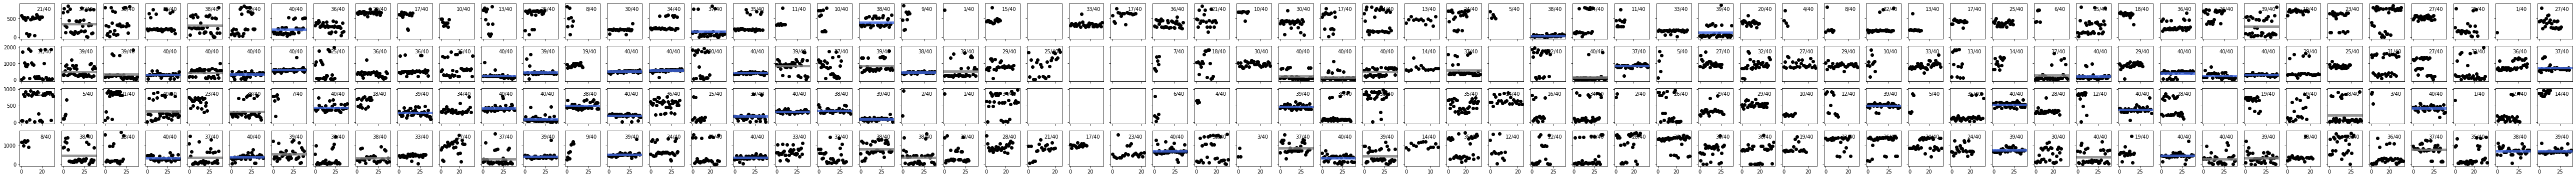

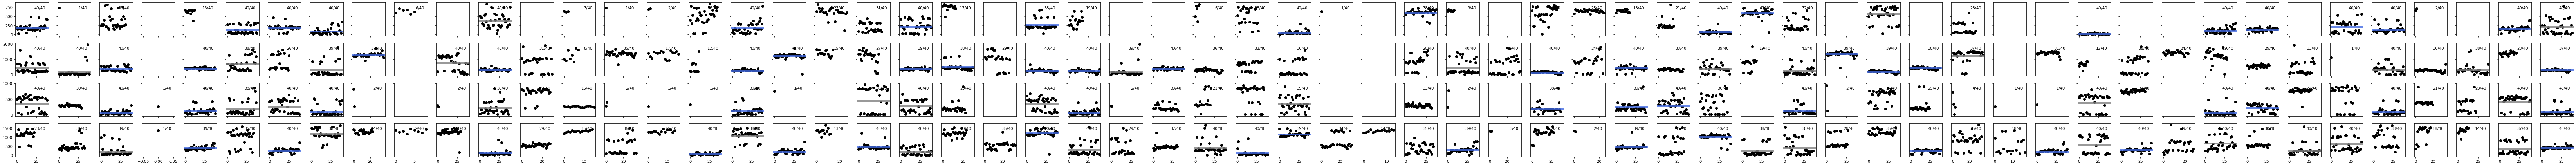

Accelerometer 0 0 0.411865 s
Accelerometer 0 5 0.483835 s
Gyroscope 0 6 0.3971425 s
Accelerometer 0 6 0.41877 s
Accelerometer 0 7 0.51679 s
Gyroscope 0 16 0.44484459 s
Accelerometer 0 17 0.4313075 s
Gyroscope 0 20 204.71315789 ms
Accelerometer 0 21 0.392225 s
Accelerometer 0 24 0.33719211 s
Accelerometer 0 30 0.556265 s
Accelerometer 0 33 0. s
Gyroscope 0 36 0.56137368 s
Gyroscope 0 40 0.47331923 s
Accelerometer 0 40 0.54558 s
Accelerometer 0 41 13.8075 ms
Accelerometer 0 49 0.5907275 s
Accelerometer 0 52 0.495615 s
Accelerometer 0 53 0.469415 s
Accelerometer 0 55 0.404825 s
Accelerometer 0 56 0.463415 s
Accelerometer 0 59 0.4428025 s
Accelerometer 1 2 0.97917615 s
Gyroscope 1 3 1.04774115 s
Accelerometer 1 4 0.93401115 s
Gyroscope 1 5 1.01564615 s
Gyroscope 1 6 0.72994115 s
Accelerometer 1 8 44.54074844 ms
Gyroscope 1 11 1.11721115 s
Accelerometer 1 11 1.02236115 s
Gyroscope 1 12 0.87674615 s
Gyroscope 1 14 0.83839865 s
Gyroscope 1 15 0.77305865 s
Gyroscope 1 17 0.93301615 s
Accelerom

In [27]:

output_mon, nconnections = plot_weights()

In [28]:
from scipy.ndimage import uniform_filter1d
from scipy.signal import find_peaks

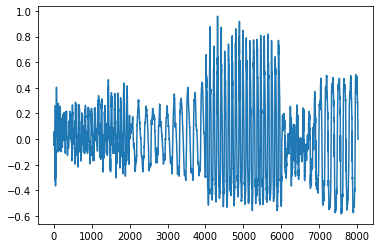

In [29]:
plt.plot(np.arange(len(x_sensor_0.values)), x_sensor_0.values)
plt.show()

Running in place
50 1 41 98.0392156862745


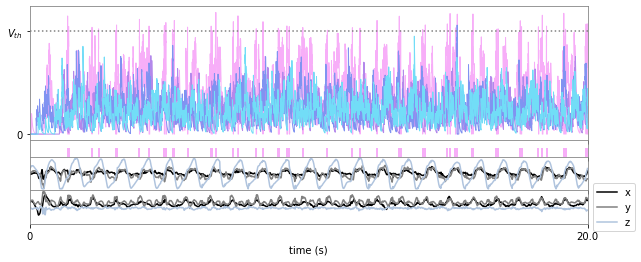

Torso rotation
20 3 38 86.95652173913044


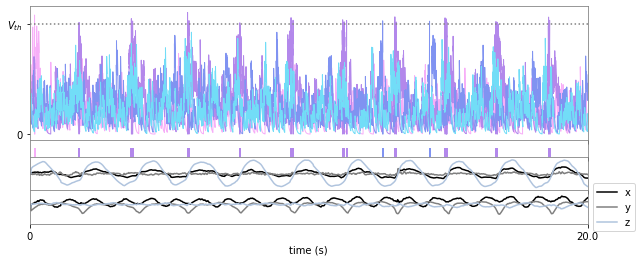

Jumping jacks
34 12 37 73.91304347826086


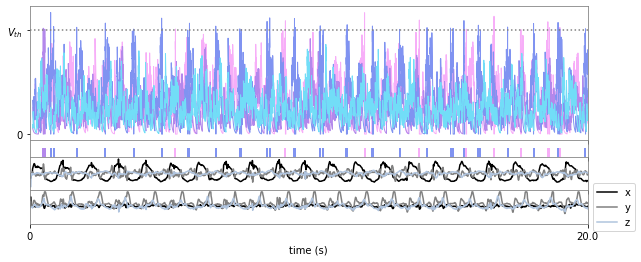

Touch feet
22 3 13 88.0


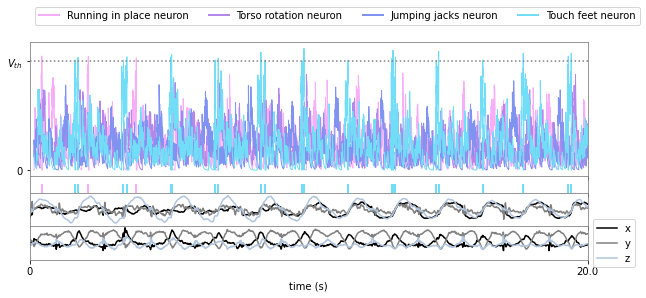

In [55]:
mon_t = output_mon[2]
mon_v = output_mon[3]
output_idx = output_mon[0]
output_spikes = output_mon[1]


online_testing_time = 20*b2.second
n_readings = int(online_testing_time/pattern_dt)




clrs = ['#f7aef8', '#b388eb', '#8093f1', '#72ddf7']

sensor_clrs = ['black', 'grey', 'lightsteelblue']

ls = ['solid', 'dotted', 'dashed', 'solid', 'dotted', 'dashed']

last_ = 0
online_time = 20*b2.second

plt.rcParams["figure.figsize"] = (4, 5)


for m, movement in enumerate(os.listdir(dir_)):
    print(movement)

    plt.rcParams['figure.figsize'] = (10, 4)

    fig , (ax_v, ax_fires, ax_gyro, ax_acc) = plt.subplots(4, gridspec_kw={'height_ratios':[4,0.5,1,1]}, sharex=True)
    
    time_mask = (mon_t>=m*((20*b2.second)+resting_time)) & (mon_t < (m+1)*((20*b2.second)+resting_time))
    window_time = mon_t[time_mask]
    windows_v_values = mon_v[m][time_mask]/nconnections[m]

    for m_, _ in enumerate(os.listdir(dir_)):
        windows_v_values = mon_v[m_][time_mask]/nconnections[m_]
        ax_v.plot(1000*window_time, windows_v_values, c=clrs[m_], lw=1, alpha=1.0, label=f'{movements_name[m_]} neuron')

    ax_v.axhline(0.23, ls= ':', color='grey')
    ax_v.set_yticks([0, 0.23])
    ax_v.set_yticklabels([0, r"$V_{th}$"])

    if m == len(movements_name)-1:
        leg = ax_v.legend(loc='center left', bbox_to_anchor=(0, 1.2), ncol=4)
    #    leg = ax_v.legend(ncol=4)
        for legobj in leg.legendHandles:
            legobj.set_linewidth(2.0)


    
    a = [x_sensor_0.values, y_sensor_0.values, z_sensor_0.values, x_sensor_1.values, y_sensor_1.values, z_sensor_1.values]
    
    for ka,axis__ in enumerate(a):

        axis_ = axis__[m*n_readings:(m+1)*n_readings]
        
        if ka<3:
            ax_gyro.plot(10*np.arange(m*n_readings, (m+1)*n_readings), axis_, c=sensor_clrs[ka], label=axis[ka])
            
            
        else:
            ax_acc.plot(10*np.arange(m*n_readings, (m+1)*n_readings), axis_, c=sensor_clrs[ka-3], label=axis[ka-3])
    
    last_ += len(axis_)+len(resting_array)

    real_output = 0
    false_output = 0
    for s,spike in enumerate(output_spikes):
        if (spike>=m*online_time) and (spike < (m+1)*online_time):
            if output_idx[s] == m:
                real_output += 1
            else:
                
                false_output += 1

            ax_fires.axvline(spike/b2.ms, lw=2, color=clrs[output_idx[s]], ymax=0.5)
    
    #ax_fires.text(1.075, 0.5, f'{real_output}/{real_output + false_output}', horizontalalignment='center', verticalalignment='center', transform=ax_fires.transAxes)

    print(real_output, false_output, n_peaks[m], 100*(real_output/(real_output + false_output)))
    
    ax_fires.set_yticks([])
    ax_gyro.set_yticks([])
    ax_acc.set_yticks([])
    ax_gyro.set_ylim(-1.1,1.1)
    ax_acc.set_ylim(-1.1,1.1)


    #ax_gyro.set_title('Gyroscope')
    #ax_acc.set_title('Accelerometer')
    #ax_gyro.legend(loc='center left')
    #ax_acc.legend(loc='center left')

    tlbls = ax_acc.get_xticklabels()
    tlbls = [int(label.get_text().replace('−', '-')) for label in tlbls]
    tlbls = [tl for tl in tlbls if tl>=0]
    tlbls = [(m)*1000*online_time/b2.second, (m+1)*1000*online_time/b2.second]
    
    ax_acc.set_xticks(tlbls)
    tlbls = [0, online_time/b2.second]
    ax_acc.set_xticklabels(tlbls)
    ax_acc.set_xlim((m)*1000*online_time/b2.second, (m+1)*1000*online_time/b2.second)

    ax_acc.set_xlabel("time (s)")
    ax_acc.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    for ax in [ax_v, ax_fires, ax_gyro, ax_acc]:
        for spine in ['bottom', 'top', 'right', 'left']:
            ax.spines[spine].set_color('grey')




    
    plt.subplots_adjust(hspace=0.0)
    plt.show()

